In [8]:
%pip install protobuf-compiler
%pip install protobuf
%pip install tensorflow_hub

  Using cached protobuf_compiler-1.0.20-py3-none-any.whl (8.6 kB)
  Using cached grpcio-1.18.0.tar.gz (14.6 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached grpcio-tools-1.18.0.tar.gz (1.9 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached colorama-0.3.3-py3-none-any.whl
  Using cached tqdm-4.31.1-py2.py3-none-any.whl (48 kB)
  Using cached bleach-2.1-py2.py3-none-any.whl (27 kB)
  Using cached html5lib-1.1-py2.py3-none-any.whl (112 kB)
  Running setup.py clean for grpcio
  Running setup.py clean for grpcio-tools
Failed to build grpcio grpcio-tools
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [143 lines of output]
      Found cython-generated files...
      running bdist_wheel
      running build
      running build_py
      running build_project_metadata
      creating python_build
      creating python_build\lib.win-amd64-3.9
      creating python_build\lib.win-amd64-3.9\grpc
      copying src\python\grpcio\grpc\_auth.py -> python_build\lib.win-amd64-3.9\grpc
      copying src\python\grpcio\grpc\_channel.py -> python_build\lib.win-amd64-3.9\grpc
      copying src\python\grpcio\grpc\_common.py -> python_build\lib.win-amd64-3.9\grpc
      copying src\python\grpcio\grpc\_grpcio_metadata.py -> python_build\lib.win-amd64-3.9\grpc
      copying src\python\grpcio\grpc\_interceptor.py -> python_build\lib.win-amd64-3.9\grpc
      copying src\python\grpcio\grpc\_plugin_wrapping.py -> python_build\lib.win-amd64-3.9\grpc
      copying src\python\grpcio\grpc\_serve

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: protobuf in c:\users\perna\appdata\local\packages\pythonsoftwarefoundation.python.3.9_qbz5n2kfra8p0\localcache\local-packages\python39\site-packages (4.24.2)




[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: C:\Users\perna\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


  Using cached tensorflow_hub-0.14.0-py2.py3-none-any.whl (90 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: C:\Users\perna\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [9]:
# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.9.2
The following GPU devices are available: 


# SIDE IMAGE

In [10]:

import tempfile
import io
import os
#from googleapiclient.discovery import build
#from googleapiclient.http import MediaIoBaseDownload
from PIL import Image, ImageOps

def resize_image(image_path, new_width=256, new_height=256, display=False):
    pil_image = Image.open(image_path)
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.LANCZOS)

    # Save the resized image to a new temporary file
    _, resized_temp_filename = tempfile.mkstemp(suffix=".jpg")
    pil_image.save(resized_temp_filename, format="JPEG", quality=90)

    print("Image resized.")

    # Optionally display the image
    if display:
        pil_image.show()

    # Return the resized temporary file path
    return resized_temp_filename

# Usage example with an image path in Google Colab
image_path = '..\Dataset\JPEGImages\Apple\S_Apple\\apple002S(5).JPG'
resized_image_path = resize_image(image_path, new_width=256, new_height=256, display=True)

def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  display_str_heights = [font.getbbox(ds)[3] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    bbox = font.getbbox(display_str)
    text_width, text_height = bbox[2], bbox[3]
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=2, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf", 25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
      
  return image

def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

C:\Users\perna\AppData\Local\Temp\ipykernel_14668\3354606374.py:10: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.LANCZOS)


Image resized.


In [11]:
downloaded_image_path = resize_image(image_path, 1280, 856, True)

C:\Users\perna\AppData\Local\Temp\ipykernel_14668\3354606374.py:10: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.LANCZOS)


Image resized.


In [12]:
import tensorflow_hub as hub

module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" 

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [13]:
import tensorflow as tf

def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [14]:
import time

def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)
  
  detections = {key: value.numpy() if isinstance(value, tf.Tensor) else value for key, value in result.items()}

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])
  
  return image_with_boxes, detections

Found 100 objects.
Inference time:  133.6824028491974
Font not found, using default font.


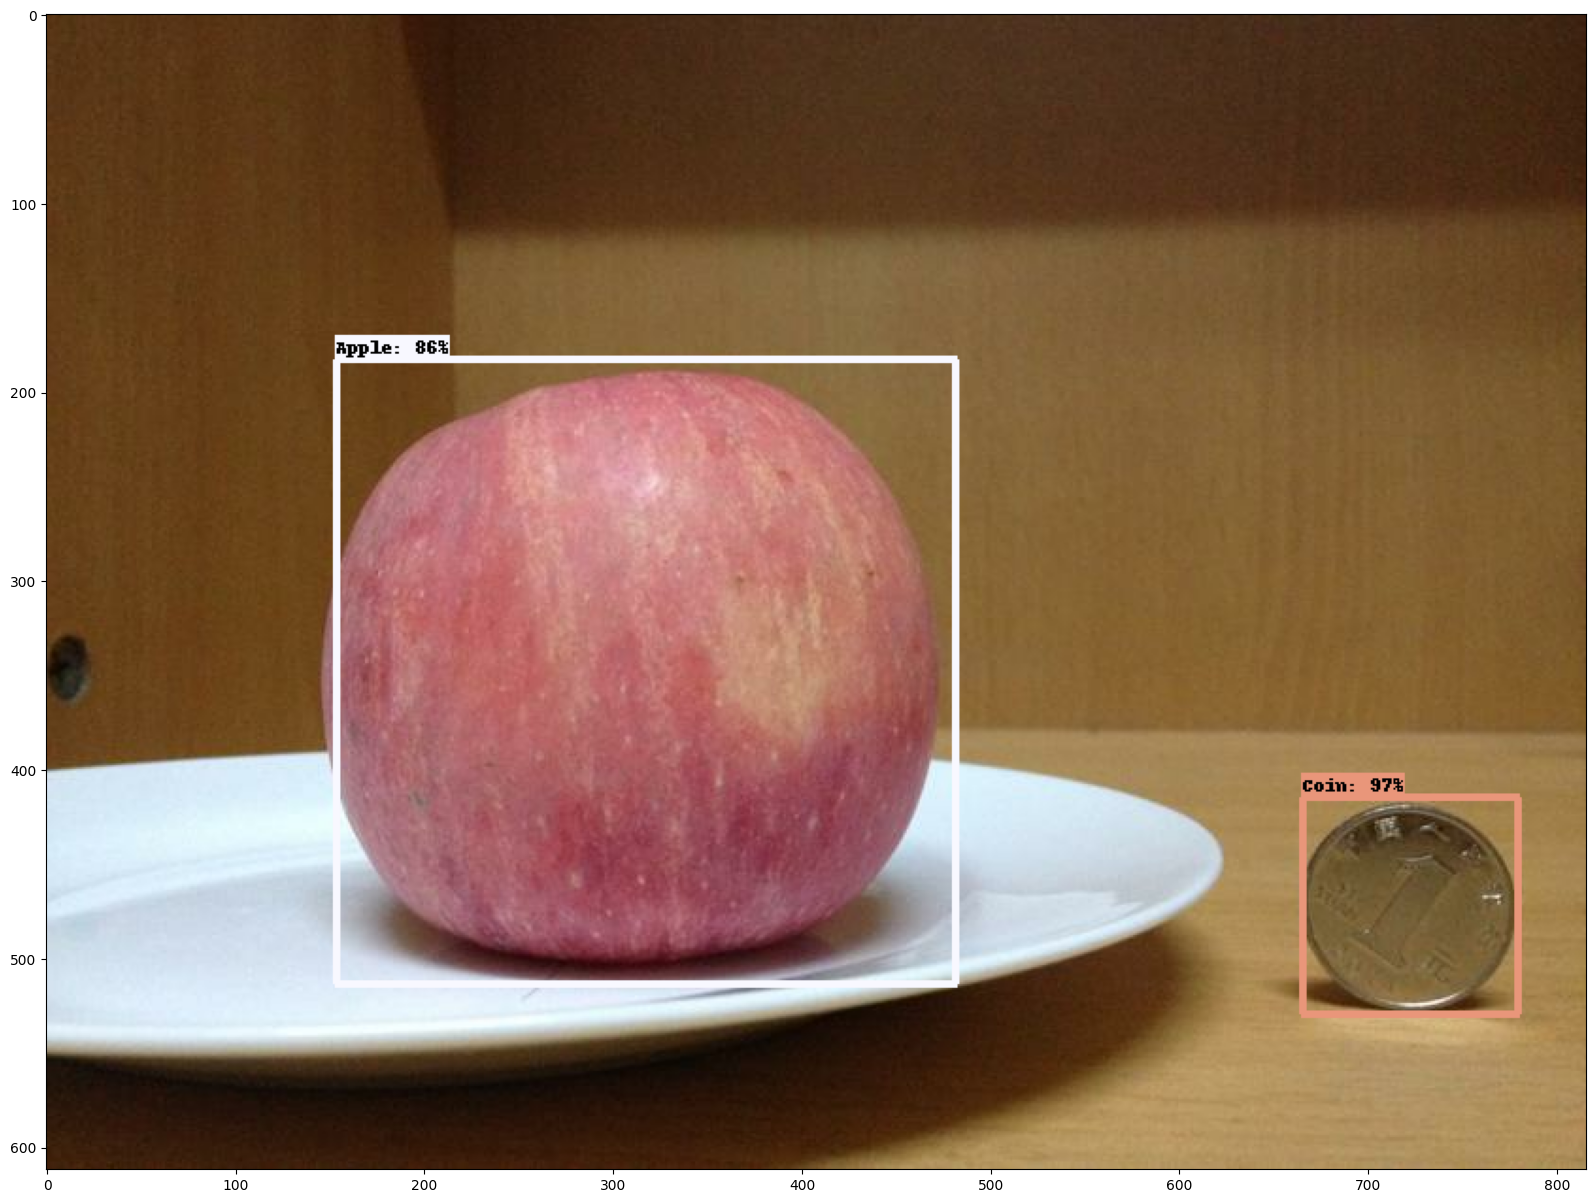

In [15]:
image_with_boxes, detections = run_detector(detector, image_path)
display_image(image_with_boxes)

In [37]:
%pip install opencv-python==4.6.0.66


     ---------------------------------------- 0.0/35.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/35.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/35.6 MB ? eta -:--:--
     --------------------------------------- 0.1/35.6 MB 744.7 kB/s eta 0:00:48
     --------------------------------------- 0.1/35.6 MB 595.3 kB/s eta 0:01:00
     --------------------------------------- 0.1/35.6 MB 607.9 kB/s eta 0:00:59
     --------------------------------------- 0.1/35.6 MB 607.9 kB/s eta 0:00:59
     --------------------------------------- 0.2/35.6 MB 719.7 kB/s eta 0:00:50
     --------------------------------------- 0.2/35.6 MB 719.7 kB/s eta 0:00:50
     --------------------------------------- 0.3/35.6 MB 681.0 kB/s eta 0:00:52
     --------------------------------------- 0.3/35.6 MB 698.7 kB/s eta 0:00:51
     --------------------------------------- 0.4/35.6 MB 813.6 kB/s eta 0:00:44
      -------------------------------------- 0.5/35.6 MB 945.8 

In [38]:
import cv2

def run_grabcut(image_path, detections):
    # Load the image
    image = cv2.imread(image_path)
    height, width = image.shape[:2]
    
    
    for box, detections['detection_class_entities'] in zip(detections['detection_boxes'], detections['detection_class_labels']):
        
        # Convert the bounding box from fractions to pixel coordinates
        ymin, xmin, ymax, xmax = box
        ymin, xmin, ymax, xmax = int(ymin * height), int(xmin * width), int(ymax * height), int(xmax * width)

        if detections['detection_class_entities']== 14:
            # Create a mask with zeros, same size as the image
            mask = np.zeros((height, width), np.uint8)

            # Create a binary mask with foreground set to 1 inside the bounding box
            mask[ymin:ymax, xmin:xmax] = 1

            # Initialize the GrabCut algorithm
            bgd_model = np.zeros((1, 65), np.float64)
            fgd_model = np.zeros((1, 65), np.float64)

            # Run the GrabCut algorithm with the initial mask
            cv2.grabCut(image, mask, None, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_MASK)

            # Create a binary mask where the foreground is True (3 and 1 are the possible states of the mask)
            mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

            # Multiply the original image with the binary mask to get the segmented image
            segmented_image = image * mask2[:, :, np.newaxis]

            # Display the original image and the segmented image
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.title('Original Image')

            plt.subplot(1, 2, 2)
            plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.title('Segmented Image')
            print(ymin, xmin, ymax, xmax)
            plt.show()

            return segmented_image, ymin, xmin, ymax, xmax
  

183 153 513 482


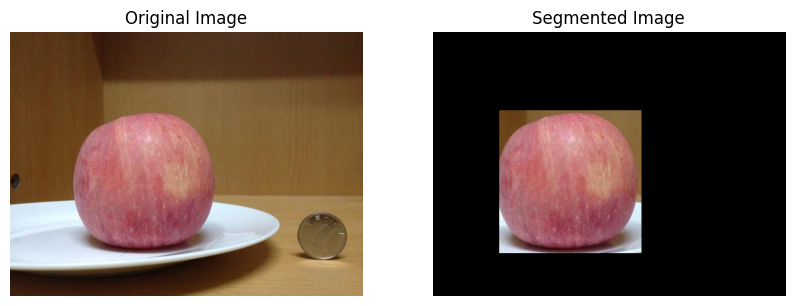

In [39]:
segmented_image_s,ymin_s, xmin_s, ymax_s, xmax_s = run_grabcut(image_path, detections)

# TOP IMAGE

In [40]:
downloaded_image_path = resize_image(image_path, 1280, 856, True)

C:\Users\perna\AppData\Local\Temp\ipykernel_14668\3354606374.py:10: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.LANCZOS)


Image resized.


Found 100 objects.
Inference time:  35.04299306869507
Font not found, using default font.


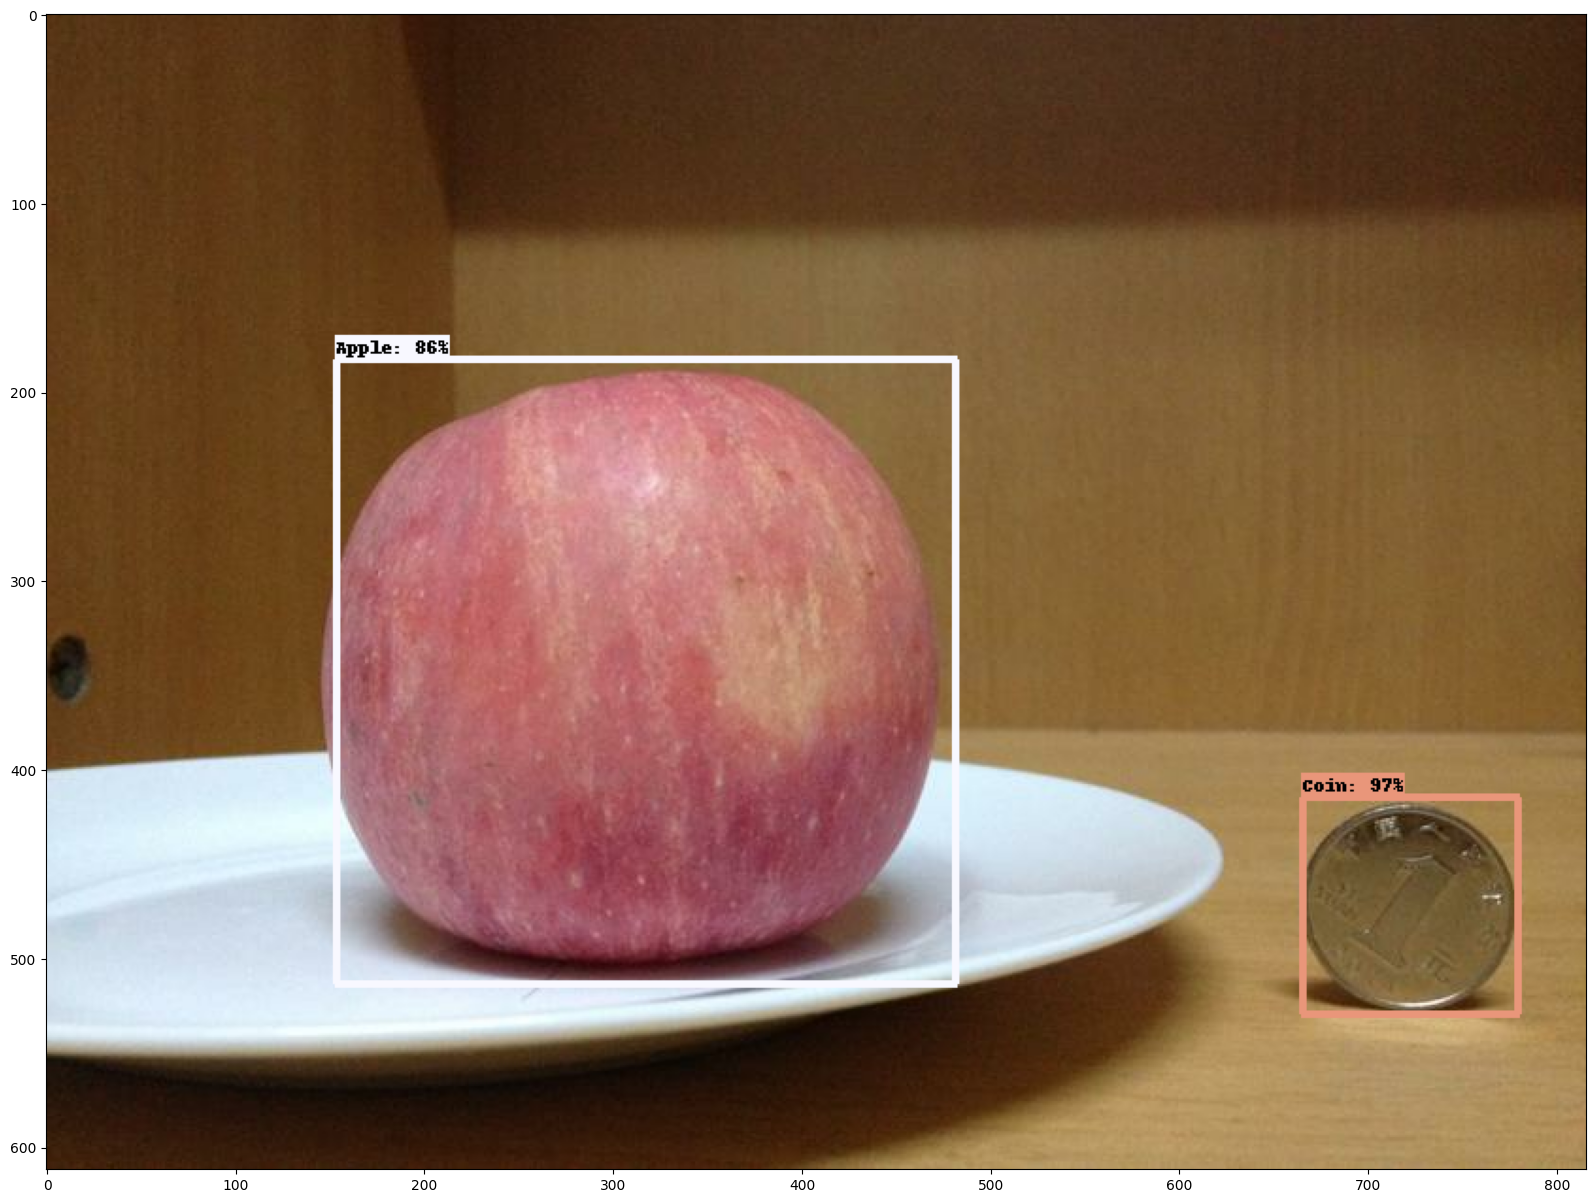

In [41]:
image_with_boxes, detections = run_detector(detector, image_path)
display_image(image_with_boxes)

183 153 513 482


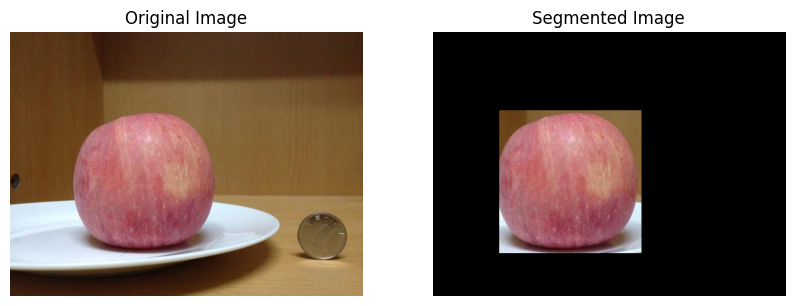

In [42]:
segmented_image_t,ymin_t, xmin_t, ymax_t, xmax_t = run_grabcut(image_path, detections)

# VOLUME ESTIMATION

In [43]:
import cv2

def calculate_pixel_per_unit(coin_diameter_mm, coin_diameter_pixel):
    pixel_per_unit = coin_diameter_pixel / coin_diameter_mm
    return pixel_per_unit

# Dimensioni reali della moneta (in millimetri)
coin_diameter_mm = 25.0  # Diametro della moneta in mm

# Diametro della moneta in pixel (misurato sull'immagine)
coin_diameter_pixel = 94.49  # Assumiamo un valore a scopo di esempio

# Calcola quanti pixel corrispondono a un millimetro sulla moneta
pixel_per_mm = calculate_pixel_per_unit(coin_diameter_mm, coin_diameter_pixel)

print(f"Pixel per millimeter: {pixel_per_mm:.2f}")


Pixel per millimeter: 3.78


In [77]:
import math

# Calcolo del fattore di conversione da millimetri a pixel
conversion_factor = coin_diameter_mm / coin_diameter_pixel

print(xmax_t-xmin_t)
print(conversion_factor)
err = 50
# Calcolo delle dimensioni dell'area del box in millimetri utilizzando il fattore di conversione
top_view_box_width_mm = (xmax_t - xmin_t - err) * conversion_factor
top_view_box_height_mm = (ymax_t - ymin_t - err) * conversion_factor

side_view_box_width_mm = (xmax_s - xmin_s - err) * conversion_factor
side_view_box_height_mm = (ymax_s - ymin_s - err) * conversion_factor


# Calcolo del volume approssimato utilizzando l'area del box (parallelepipedo)

volume = int(top_view_box_width_mm) * int(side_view_box_height_mm) * int(top_view_box_height_mm) 
print(int(top_view_box_width_mm),int(side_view_box_height_mm),int(top_view_box_height_mm)) 
print(volume/1000)
# Calorie per unità di volume (esempio)
calories_per_cubic_mm = 2.5  # Valore calorico per unità di volume

# Calcolo delle calorie stimate
estimated_calories = calories_per_cubic_mm * volume

# Stampare i risultati
print("Dimensioni stimate del box della mela dalla vista dall'alto (larghezza x altezza):",
      top_view_box_width_mm, "mm x", top_view_box_height_mm, "mm")
print("Dimensioni stimate del box della mela dalla vista laterale (larghezza x altezza):",
      side_view_box_width_mm, "mm x", side_view_box_height_mm, "mm")
print("Volume medio stimato:", volume, "mm^3")
print("Calorie stimate:", estimated_calories, "calorie")


329
0.26457826224997355
73 74 74
399.748
Dimensioni stimate del box della mela dalla vista dall'alto (larghezza x altezza): 73.81733516774263 mm x 74.0819134299926 mm
Dimensioni stimate del box della mela dalla vista laterale (larghezza x altezza): 73.81733516774263 mm x 74.0819134299926 mm
Volume medio stimato: 399748 mm^3
Calorie stimate: 999370.0 calorie
